In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c playground-series-s5e1
!unzip /content/playground-series-s5e1.zip
!rm /content/playground-series-s5e1.zip

Mounted at /content/drive
  0% 0.00/2.26M [00:00<?, ?B/s]
100% 2.26M/2.26M [00:00<00:00, 141MB/s]
Archive:  /content/playground-series-s5e1.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# !pip install autogluon.tabular[all]
# !pip install holidays
!pip install pytorch-lightning
!pip install pytorch-forecasting
!pip install pytorch_optimizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.9/181.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.9/221.9 kB 9.6 MB/s eta 0:00:00


## Import Packages
https://www.kaggle.com/code/ivyzang/1st-place-solution-less-is-more/notebook

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, GammaRegressor, Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from keras_tuner import HyperModel
# from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import layers, models

# from autogluon.tabular import TabularDataset, TabularPredictor
import holidays
import datetime as dt

# Pytorch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

## Load Data

In [ ]:
train = pd.read_csv('/content/train.csv', index_col = 0)
test = pd.read_csv('/content/test.csv', index_col = 0)
sub = pd.read_csv('/content/sample_submission.csv')

In [ ]:
# test2 = test.copy(deep = True)

### Feature Engineer

In [ ]:
condition = ((train['country'] == 'Canada') &
      (train['store'] == 'Discount Stickers') &
      (train['product'] == 'Kerneler' ))

train.loc[condition, 'num_sold'] = train.loc[condition, 'num_sold'].ffill()


condition = ((train['country'] == 'Kenya') &
      (train['store'] == 'Discount Stickers') &
      (train['product'] == 'Kerneler' ))

train.loc[condition, 'num_sold'] = train.loc[condition, 'num_sold'].ffill()

condition = ((train['country'] == 'Kenya') &
      (train['store'] == 'Discount Stickers') &
      (train['product'] == 'Kerneler Dark Mode' ))

train.loc[condition, 'num_sold'] = train.loc[condition, 'num_sold'].ffill()

In [ ]:
train = train.dropna()

In [ ]:
import pandas as pd
import datetime as dt
import holidays

def extract_date_features_with_holidays_and_special_dates(df, date_column, countries, years):
    """
    Extracts date-related features, integrates holiday information, and adds special date features.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the date column.
    date_column (str): The name of the column containing datetime values.
    countries (list): List of country codes for generating holiday data.
    years (list): List of years for which to generate holiday data.

    Returns:
    pd.DataFrame: The DataFrame with additional date, holiday, and special date features.
    """
    # Ensure date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    # Extract date-related features
    df['year'] = df[date_column].dt.year
    df['week'] = df[date_column].dt.dayofweek
    df['month'] = df[date_column].dt.month
    df['day'] = df[date_column].dt.day
    df['time_no'] = (df[date_column] - dt.datetime(2010, 1, 1)) // dt.timedelta(days=1)

    # Generate holidays DataFrame
    holiday_dfs = []
    for year in years:
        for country in countries:
            for date, holiday_name in sorted(holidays.CountryHoliday(country, years=year).items()):
                holiday_df = pd.DataFrame({"date": [date], "country": [country]})
                holiday_dfs.append(holiday_df)

    df_holidays = pd.concat(holiday_dfs, ignore_index=True)
    df_holidays['date'] = pd.to_datetime(df_holidays['date'])
    df_holidays['tmp'] = 1  # Temporary marker for merging holidays

    # Merge holiday information into the main DataFrame
    df = df.merge(df_holidays, on=['date', 'country'], how='left')
    df['is_holiday'] = df['tmp'].fillna(0).astype(int)
    df.drop(columns=['tmp'], inplace=True)  # Drop temporary marker

    # Add shifted holiday columns
    holidays_columns = []
    for i in range(10):  # Generate 10 days of shifted holidays
        column = f'holiday_{i}'
        shifted = df_holidays.rename(columns={'tmp': column}).copy()
        shifted['date'] = shifted['date'] + dt.timedelta(days=i)
        df = pd.merge(df, shifted[['date', 'country', column]], on=['country', 'date'], how='left')
        df[column] = df[column].fillna(0).astype(int)
        holidays_columns.append(column)

    # Add special date features for New Year's holidays
    special_date_columns = []
    for day in range(25, 32):  # Days from Dec 25 to Dec 31
        column = f'day_12_{day}'
        df[column] = ((df['month'] == 12) & (df['day'] == day)).astype(float)
        special_date_columns.append(column)
    for day in range(1, 11):  # Days from Jan 1 to Jan 10
        column = f'day_1_{day}'
        df[column] = ((df['month'] == 1) & (df['day'] == day)).astype(float)
        special_date_columns.append(column)

    return df, holidays_columns, special_date_columns

# Example usage:
train, holidays_cols, special_date_cols = extract_date_features_with_holidays_and_special_dates(
    train, 'date', countries=train['country'].unique().tolist(), years=[2010, 2011,2012, 2013, 2014, 2015, 2016]
)
test, _, _ = extract_date_features_with_holidays_and_special_dates(
    test, 'date', countries=train['country'].unique().tolist(), years=[2017,2018,2019]
)


In [ ]:
import requests
import numpy as np
import pandas as pd

def add_relative_gdp_features(train_df, test_df, countries, years):
    """
    Adds relative GDP per capita features and their log transformations to train and test DataFrames.

    Parameters:
    train_df (pd.DataFrame): Training DataFrame with a 'country' and 'date' column.
    test_df (pd.DataFrame): Testing DataFrame with a 'country' and 'date' column.
    countries (list): List of country names to fetch GDP data for.
    years (list): List of years to fetch GDP data for.

    Returns:
    pd.DataFrame, pd.DataFrame: Updated train and test DataFrames with relative GDP features.
    """
    # Map country names to their alpha-3 codes for the World Bank API
    alpha3 = {
        'Canada': 'CAN', 'Finland': 'FIN', 'Italy': 'ITA',
        'Kenya': 'KEN', 'Norway': 'NOR', 'Singapore': 'SGP'
    }

    # Fetch GDP per capita data for each country and year
    def get_gdp_per_capita(country, year):
        try:
            code = alpha3.get(country)
            if not code:
                return None
            url = f"https://api.worldbank.org/v2/country/{code}/indicator/NY.GDP.PCAP.CD?date={year}&format=json"
            response = requests.get(url).json()
            return response[1][0]['value'] if response and len(response) > 1 else None
        except Exception as e:
            print(f"Error fetching data for {country}, {year}: {e}")
            return None

    # Create a DataFrame to store GDP data
    gdp_data = []
    for country in countries:
        country_gdp = []
        for year in years:
            gdp_value = get_gdp_per_capita(country, year)
            country_gdp.append(gdp_value)
        gdp_data.append(country_gdp)

    # Normalize GDP data
    gdp_array = np.array(gdp_data, dtype=np.float64)
    gdp_normalized = gdp_array / np.nansum(gdp_array, axis=0)  # Normalize across countries for each year

    # Convert normalized GDP data into a DataFrame
    rel_gdp_df = pd.DataFrame(gdp_normalized, index=countries, columns=years)

    # Add relative GDP and log-relative GDP features
    def add_gdp_features(df):
        df['year'] = pd.to_datetime(df['date']).dt.year

        # Add relative GDP and log-relative GDP using the computed rel_gdp_df
        df['rel_gdp'] = df.apply(lambda s: rel_gdp_df.loc[s['country'], s['year']], axis=1)
        df['log_rel_gdp'] = np.log(df['rel_gdp'])

        return df

    train_df = add_gdp_features(train_df)
    test_df = add_gdp_features(test_df)

    return train_df, test_df

# Example Usage
# Specify the countries and years
countries = ['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore']
years = list(range(2010, 2020))

# Apply the function to train and test DataFrames
train, test = add_relative_gdp_features(train, test, countries, years)


In [ ]:
def add_sin_wave_features(df, uniques):
    """
    Adds sinusoidal features and product cross-sin wave features to the dataframe.

    Parameters:
    df (pd.DataFrame): The dataframe to modify.
    uniques (dict): Dictionary containing unique categories for features like 'product'.

    Returns:
    pd.DataFrame: Modified dataframe with added features.
    """
    # Add sinusoidal features
    year_columns = ['year_sin_1', 'year_cos_1', 'year_sin_0.5', 'year_cos_0.5']
    df['year_sin_1'] = np.sin(np.pi * df['time_no'] / 182.5)
    df['year_cos_1'] = np.cos(np.pi * df['time_no'] / 182.5)
    df['year_sin_0.5'] = np.sin(np.pi * df['time_no'] / 365.0)
    df['year_cos_0.5'] = np.cos(np.pi * df['time_no'] / 365.0)

    # Add product cross-sin wave features
    product_year_columns = []
    for product in uniques['product']:
        df[product] = (df['product'] == product).astype(float)
        for year in year_columns:
            product_year = f"{product}_{year}"
            df[product_year] = df[product] * df[year]
            product_year_columns.append(product_year)

    return df, year_columns, product_year_columns

# Example Usage
uniques = {'product': ['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode']}  # Replace with actual unique products
train, train_year_columns, train_product_year_columns = add_sin_wave_features(train, uniques)
test, test_year_columns, test_product_year_columns = add_sin_wave_features(test, uniques)

## EDA

In [ ]:
train.shape, test.shape

((230130, 40), (98550, 39))

In [ ]:
train.isna().sum()

,0
date,0
country,0
store,0
product,0
num_sold,8806


In [ ]:
test.isna().sum()

,0
date,0
country,0
store,0
product,0


<Axes: >

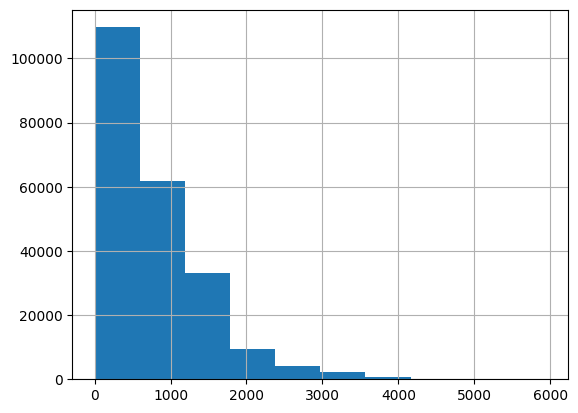

In [ ]:
train['num_sold'].hist()

In [ ]:
train[train['num_sold'].isna()].fillna('hi').groupby(['country',	'store',	'product']).num_sold.value_counts()

country  store                 product             num_sold
Canada   Discount Stickers     Holographic Goose   hi          2557
                               Kerneler            hi             1
         Premium Sticker Mart  Holographic Goose   hi           380
         Stickers for Less     Holographic Goose   hi          1308
Kenya    Discount Stickers     Holographic Goose   hi          2557
                               Kerneler            hi            63
                               Kerneler Dark Mode  hi             1
         Premium Sticker Mart  Holographic Goose   hi           646
         Stickers for Less     Holographic Goose   hi          1358
Name: count, dtype: int64

In [ ]:
uniques = {}
for column in train.columns:
    uniques[column] = train[column].unique().tolist()
print(uniques['country'])
print(uniques['store'])
print(uniques['product'])

['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore']
['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart']
['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler', 'Kerneler Dark Mode']


In [ ]:
train.date.min(), train.date.max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2016-12-31 00:00:00'))

## Pytorch Transformer Model

In [ ]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [ ]:
train["time_idx"] = train["date"].dt.year * 12 + train["date"].dt.month
train["time_idx"] -= train["time_idx"].min()

test["time_idx"] = test["date"].dt.year * 12 + test["date"].dt.month
test["time_idx"] -= test["time_idx"].min()

In [ ]:
max_prediction_length = 6
max_encoder_length = train.date.nunique()
training_cutoff = train["time_idx"].max() - max_prediction_length

In [ ]:
train["month"] = train.date.dt.month.astype(str).astype("category")  # categories have be strings'
test["month"] = test.date.dt.month.astype(str).astype("category")  # categories have be strings

In [ ]:
train["log_num_sold"] = np.log(train.num_sold + 1e-8)
train["avg_num_sold_by_country"] = train.groupby(["time_idx", "country"], observed=True).num_sold.transform("mean")
train["avg_num_sold_by_store"] = train.groupby(["time_idx", "store"], observed=True).num_sold.transform("mean")
train["avg_num_sold_by_product"] = train.groupby(["time_idx", "product"], observed=True).num_sold.transform("mean")

# test["log_num_sold"] = np.log(test.num_sold + 1e-8)
# test["avg_num_sold_by_country"] = test.groupby(["time_idx", "country"], observed=True).num_sold.transform("mean")
# test["avg_num_sold_by_store"] = test.groupby(["time_idx", "store"], observed=True).num_sold.transform("mean")
# test["avg_num_sold_by_product"] = test.groupby(["time_idx", "product"], observed=True).num_sold.transform("mean")

In [ ]:
train[lambda x: x.time_idx <= training_cutoff]

,date,country,store,product,num_sold,time_idx,month,log_num_sold,avg_num_sold_by_country,avg_num_sold_by_store,avg_num_sold_by_product
id,,,,,,,,,,,
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,0,1,6.880384,818.285377,417.270737,1165.845878
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,0,1,6.809039,818.285377,417.270737,1038.630824
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,0,1,6.047372,818.285377,417.270737,507.935484
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,0,1,6.196444,818.285377,417.270737,653.191756
5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0,0,1,5.703782,818.285377,823.560894,219.297297
...,...,...,...,...,...,...,...,...,...,...,...
213565,2016-06-30,Singapore,Premium Sticker Mart,Holographic Goose,231.0,77,6,5.442418,876.835556,861.620571,146.889423
213566,2016-06-30,Singapore,Premium Sticker Mart,Kaggle,1768.0,77,6,7.477604,876.835556,861.620571,1054.253704
213567,2016-06-30,Singapore,Premium Sticker Mart,Kaggle Tiers,1570.0,77,6,7.358831,876.835556,861.620571,906.637037


In [ ]:
training = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="num_sold",
    group_ids=["country", "store", "product"],
    min_encoder_length=1,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["country", "store", "product"],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=[ "month"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "num_sold",
        "log_num_sold",
        "avg_num_sold_by_country",
        "avg_num_sold_by_store",
        "avg_num_sold_by_product",
    ],
    allow_missing_timesteps=True,
    target_normalizer=GroupNormalizer(
        groups=["country", "store", "product"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [ ]:
for col in ["country", "store", "product", "month"]:
    print(f"{col} unique values: {train[col].unique()}")

country unique values: ['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']
store unique values: ['Discount Stickers' 'Stickers for Less' 'Premium Sticker Mart']
product unique values: ['Kaggle' 'Kaggle Tiers' 'Kerneler' 'Kerneler Dark Mode'
 'Holographic Goose']
month unique values: ['1', '2', '3', '4', '5', ..., '8', '9', '10', '11', '12']
Length: 12
Categories (12, object): ['1', '10', '11', '12', ..., '6', '7', '8', '9']


In [ ]:
# Check for empty or sparse group combinations
group_counts = train.groupby(["country", "store", "product"]).size()
print(group_counts[group_counts == 0])  # Check for empty groups

Series([], dtype: int64)


In [ ]:
group_counts = train.groupby(["country", "store", "product"]).size()
print(f"Minimum group size: {group_counts.min()}")
print(f"Maximum group size: {group_counts.max()}")

Minimum group size: 1199
Maximum group size: 2557


In [ ]:
# Check for extreme or missing values in the target column
print(train["num_sold"].describe())
print(f"Missing target values: {train['num_sold'].isnull().sum()}")

count    221324.000000
mean        752.308977
std         690.181893
min           5.000000
25%         219.000000
50%         604.000000
75%        1114.000000
max        5939.000000
Name: num_sold, dtype: float64
Missing target values: 0


In [ ]:
for col in ["country", "store", "product", "month"]:
    print(f"{col}: {train[col].nunique()} unique categories")

country: 6 unique categories
store: 3 unique categories
product: 5 unique categories
month: 12 unique categories


### Train Model

In [ ]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

<ipython-input-14-55611457b6c8>:2: UserWarning: In pytorch-forecasting models, from version 1.2.0, the default optimizer will be 'adam', in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_m

tensor(57.7746, device='cuda:0')

In [ ]:
# configure network and trainer
from pytorch_lightning import Trainer
# from lightning.pytorch import Trainer
pl.seed_everything(30)
trainer = Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="ranger",
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

INFO:lightning_fabric.utilities.seed:Seed set to 30
INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 9.3k


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [ ]:
# # find optimal learning rate
# # from pytorch_lightning.tuner import Tuner
# # from torch_optimizer import Ranger

# res = Tuner(trainer).lr_find(
#     tft,
#     train_dataloaders=train_dataloader,
#     val_dataloaders=val_dataloader,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.048977881936844644
INFO: Restoring states from the checkpoint path at /content/.lr_find_491146a9-1941-4ecf-a8b4-ba8e3eaa1c6a.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_491146a9-1941-4ecf-a8b4-ba8e3eaa1c6a.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_491146a9-1941-4ecf-a8b4-ba8e3eaa1c6a.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_491146a9-1941-4ecf-a8b4-ba8e3eaa1c6a.ckpt


_TunerExitException: 

In [ ]:
# configure network and trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch import Trainer

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate

trainer = Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    # logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.048977881936844644,#0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="adam",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 22.1k


In [ ]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 125    | train
3  | prescalers                         | ModuleDict                      | 160    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 2.1 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.6 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K  | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [ ]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
MAE()(predictions.output, predictions.y)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(56.3680, device='cuda:0')

### Predict

In [ ]:
group_medians = (
    train.groupby(["country", "store", "product", "time_idx"])["num_sold"]
    .median()
    .reset_index()
    # .rename(columns={"num_sold": "median_num_sold"})
)

In [ ]:
test = test.merge(
    group_medians,
    on=["country", "store", "product", "time_idx"],
    how="left"
)
test['num_sold'] = test['num_sold'].fillna(0)

In [ ]:
test["log_num_sold"] = np.log(test.num_sold + 1e-8)
test["avg_num_sold_by_country"] = test.groupby(["time_idx", "country"], observed=True).num_sold.transform("mean")
test["avg_num_sold_by_store"] = test.groupby(["time_idx", "store"], observed=True).num_sold.transform("mean")
test["avg_num_sold_by_product"] = test.groupby(["time_idx", "product"], observed=True).num_sold.transform("mean")

In [ ]:
test_dataset = TimeSeriesDataSet(
    test,
    time_idx="time_idx",
    target="num_sold",
    group_ids=["country", "store", "product"],
    min_encoder_length= 1,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["country", "store", "product"],
    time_varying_known_categoricals=["month"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=[
        "num_sold",
        "log_num_sold",
        "avg_num_sold_by_country",
        "avg_num_sold_by_store",
        "avg_num_sold_by_product",
    ],
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [ ]:
# Create test dataloader
test_dataloader = test_dataset.to_dataloader(batch_size=64, shuffle=False)

# Predict
predictions = best_tft.predict(test_dataloader, return_x=True)

# Attach predictions to test DataFrame
# test["predicted_num_sold"] = predictions.numpy()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
predictions, x = predictions.cpu().numpy()

In [ ]:
len(predictions)

188730

In [ ]:
test

,date,country,store,product,time_idx,month,num_sold,log_num_sold,avg_num_sold_by_country,avg_num_sold_by_store,avg_num_sold_by_product
0,2017-01-01,Canada,Discount Stickers,Holographic Goose,0,1,0.0,-18.420681,720.866667,373.966667,172.833333
1,2017-01-01,Canada,Discount Stickers,Kaggle,0,1,654.0,6.483107,720.866667,373.966667,1120.388889
2,2017-01-01,Canada,Discount Stickers,Kaggle Tiers,0,1,592.0,6.383507,720.866667,373.966667,1000.333333
3,2017-01-01,Canada,Discount Stickers,Kerneler,0,1,290.0,5.669881,720.866667,373.966667,487.666667
4,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode,0,1,365.0,5.899897,720.866667,373.966667,631.222222
...,...,...,...,...,...,...,...,...,...,...,...
98545,2019-12-31,Singapore,Premium Sticker Mart,Holographic Goose,35,12,296.0,5.690359,830.666667,972.800000,191.888889
98546,2019-12-31,Singapore,Premium Sticker Mart,Kaggle,35,12,1903.0,7.551187,830.666667,972.800000,1267.055556
98547,2019-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,35,12,1500.0,7.313220,830.666667,972.800000,970.611111
98548,2019-12-31,Singapore,Premium Sticker Mart,Kerneler,35,12,889.0,6.790097,830.666667,972.800000,595.055556


## AutoML Model
1. base WeightedEnsemble_L3	-0.070351	(Score: 0.13369)
2. feature engineer: WeightedEnsemble_L3	-0.067273 (Score: 0.14665)

In [ ]:
label ='num_sold'
metric ='mape'
time_limit = 600

excluded_model_types = ['KNN']

In [ ]:
train.columns.tolist()

['date',
 'country',
 'store',
 'product',
 'num_sold',
 'year',
 'week',
 'month',
 'day',
 'time_no',
 'is_holiday',
 'holiday_0',
 'holiday_1',
 'holiday_2',
 'holiday_3',
 'holiday_4',
 'holiday_5',
 'holiday_6',
 'holiday_7',
 'holiday_8',
 'holiday_9',
 'day_12_25',
 'day_12_26',
 'day_12_27',
 'day_12_28',
 'day_12_29',
 'day_12_30',
 'day_12_31',
 'day_1_1',
 'day_1_2',
 'day_1_3',
 'day_1_4',
 'day_1_5',
 'day_1_6',
 'day_1_7',
 'day_1_8',
 'day_1_9',
 'day_1_10',
 'rel_gdp',
 'log_rel_gdp',
 'year_sin_1',
 'year_cos_1',
 'year_sin_0.5',
 'year_cos_0.5',
 'Holographic Goose',
 'Holographic Goose_year_sin_1',
 'Holographic Goose_year_cos_1',
 'Holographic Goose_year_sin_0.5',
 'Holographic Goose_year_cos_0.5',
 'Kaggle',
 'Kaggle_year_sin_1',
 'Kaggle_year_cos_1',
 'Kaggle_year_sin_0.5',
 'Kaggle_year_cos_0.5',
 'Kaggle Tiers',
 'Kaggle Tiers_year_sin_1',
 'Kaggle Tiers_year_cos_1',
 'Kaggle Tiers_year_sin_0.5',
 'Kaggle Tiers_year_cos_0.5',
 'Kerneler',
 'Kerneler_year_sin_1',

In [ ]:
predictor = TabularPredictor(label, eval_metric=metric).fit(train.drop(['year', 'week',
       'month', 'day', 'time_no'], axis = 1).dropna(),
                                                            auto_stack=True,excluded_model_types=excluded_model_types,
                                                            time_limit=time_limit, presets='best_quality', holdout_frac = 0.2)

No path specified. Models will be saved in: "AutogluonModels/ag-20250101_020221"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.42 GB / 12.67 GB (74.4%)
Disk Space Avail:   74.03 GB / 107.72 GB (68.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fi

In [ ]:
predictor.leaderboard()

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-0.073255,mean_absolute_percentage_error,82.635559,395.301462,0.005750,0.277613,3,True,4
1,LightGBMXT_BAG_L2,-0.075778,mean_absolute_percentage_error,82.629809,395.023848,19.172022,129.402317,2,True,3
2,LightGBMXT_BAG_L1,-0.084050,mean_absolute_percentage_error,63.457786,265.621531,63.457786,265.621531,1,True,1
3,WeightedEnsemble_L2,-0.084050,mean_absolute_percentage_error,63.468367,265.638118,0.010581,0.016587,2,True,2


In [ ]:
# Make preds
y_pred = predictor.predict(test)

In [ ]:
y_pred.index = test2.index

In [ ]:
y_pred.to_csv('/content/drive/MyDrive/Output/sub.csv')

In [ ]:
# Submit
!kaggle competitions submit -c playground-series-s5e1 -f /content/drive/MyDrive/Output/sub.csv -m "feat eng"

100% 1.57M/1.57M [00:00<00:00, 2.31MB/s]
Successfully submitted to Forecasting Sticker Sales

In [ ]:
train_preds = predictor.predict(train.dropna())

In [ ]:
train[label], train_preds

(0            NaN
 1          973.0
 2          906.0
 3          423.0
 4          491.0
            ...  
 230125     466.0
 230126    2907.0
 230127    2299.0
 230128    1242.0
 230129    1622.0
 Name: num_sold, Length: 230130, dtype: float64,
 id
 1          904.452209
 2          832.967712
 3          406.785889
 4          472.236847
 5          287.231934
              ...     
 230125     440.348236
 230126    2637.321777
 230127    2129.339111
 230128    1280.911743
 230129    1511.813477
 Name: num_sold, Length: 221259, dtype: float32)

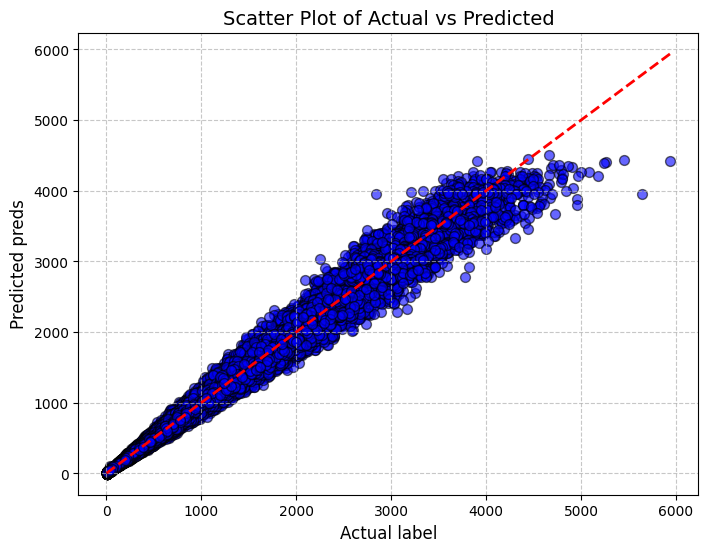

In [ ]:
def plot_scatter(actuals, predictions, label_column_name, prediction_column_name):
    """
    Plots a scatter plot of actual vs. predicted values.

    Parameters:
    actuals (pd.Series): The actual target values.
    predictions (pd.Series): The predicted values.
    label_column_name (str): The name of the label (actual) column.
    prediction_column_name (str): The name of the prediction column.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(actuals, predictions, alpha=0.6, color='b', edgecolor='k', s=50)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', linewidth=2)
    plt.title('Scatter Plot of Actual vs Predicted', fontsize=14)
    plt.xlabel(f'Actual {label_column_name}', fontsize=12)
    plt.ylabel(f'Predicted {prediction_column_name}', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Example Usage

prediction_column = 'preds'  # Replace with your actual column name for predictions
plot_scatter(train[label].loc[train_preds.index], train_preds, label_column, prediction_column)